In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam




In [28]:
time_window = 5

In [29]:
df = pd.read_csv(r"CNNdata\fulldata.csv")
df["DateTime"] = pd.to_datetime(df["DateTime"])
df.set_index(df["DateTime"], inplace=True)
df = df.resample("50ms").mean()
df = df.fillna(method='ffill')  # Forward fill
df
del df["DateTime"]


C:\Users\dbjac\AppData\Local\Temp\ipykernel_10036\511533882.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')  # Forward fill


In [30]:
print(df.dtypes)
print(df.isnull().sum().cumsum())


Price                 float64
Mid                   float64
WAP                   float64
Returns               float64
Spread                float64
                       ...   
Is_3                  float64
Is_4                  float64
Is_5                  float64
Next_Mid_Direction    float64
Mid_Change            float64
Length: 71, dtype: object
Price                 0
Mid                   0
WAP                   0
Returns               0
Spread                0
                     ..
Is_3                  0
Is_4                  0
Is_5                  0
Next_Mid_Direction    0
Mid_Change            0
Length: 71, dtype: int64


In [31]:
for index in df:
    print(index,df[index].isna().sum())

Price 0
Mid 0
WAP 0
Returns 0
Spread 0
Delta_AP_1 0
Delta_BP_1 0
Size 0
Direction 0
MA5_Order_Direction 0
MA10_Order_Direction 0
MA15_Order_Direction 0
Ask_Price_Level_1 0
Ask_Volume_Level_1 0
Bid_Price_Level_1 0
Bid_Volume_Level_1 0
Ask_Price_Level_2 0
Ask_Volume_Level_2 0
Bid_Price_Level_2 0
Bid_Volume_Level_2 0
Ask_Price_Level_3 0
Ask_Volume_Level_3 0
Bid_Price_Level_3 0
Bid_Volume_Level_3 0
Ask_Price_Level_4 0
Ask_Volume_Level_4 0
Bid_Price_Level_4 0
Bid_Volume_Level_4 0
Ask_Price_Level_5 0
Ask_Volume_Level_5 0
Bid_Price_Level_5 0
Bid_Volume_Level_5 0
Ask_Price_Level_6 0
Ask_Volume_Level_6 0
Bid_Price_Level_6 0
Bid_Volume_Level_6 0
Ask_Price_Level_7 0
Ask_Volume_Level_7 0
Bid_Price_Level_7 0
Bid_Volume_Level_7 0
Ask_Price_Level_8 0
Ask_Volume_Level_8 0
Bid_Price_Level_8 0
Bid_Volume_Level_8 0
Ask_Price_Level_9 0
Ask_Volume_Level_9 0
Bid_Price_Level_9 0
Bid_Volume_Level_9 0
Ask_Price_Level_10 0
Ask_Volume_Level_10 0
Bid_Price_Level_10 0
Bid_Volume_Level_10 0
Ask_Volume 0
Bid_Volume 

(array([1.19042277e-01, 6.94466703e-04, 5.56321250e-02, 7.09531288e-02,
        2.00455143e-01, 4.32365354e+00, 7.53122429e-02, 4.83348825e-02,
        9.82937487e-04, 1.04939261e-01]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

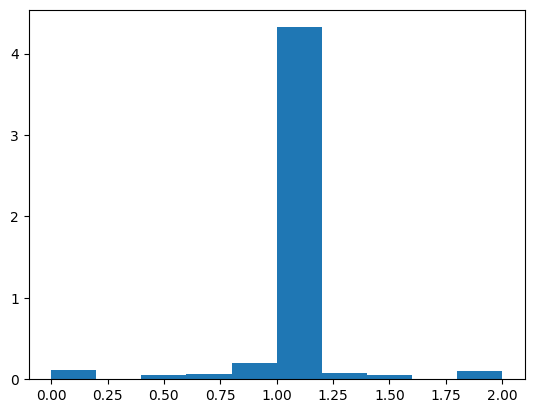

In [32]:
plt.hist(df["Next_Mid_Direction"],density=True)
#plt.hist(df["Mid_Change"],density=True)

In [33]:

X = df.drop(["Next_Mid_Direction","Mid_Change"], axis=1) #Features
y = df["Next_Mid_Direction"] #Target

train_size = int(len(df) * 0.7)  # 70% for training
val_size = int(len(df) * 0.15)    # 15% for validation
test_size = len(df) - train_size - val_size #Remaining for testing

X = df.drop(["Next_Mid_Direction","Mid_Change"], axis=1)
y = df["Next_Mid_Direction"]

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]


df["Size"] = df["Size"].astype(np.float64)

numerical_cols = X_train.select_dtypes(include=np.float64).columns
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

X_train.head()



C:\Users\dbjac\AppData\Local\Temp\ipykernel_10036\4103593463.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
C:\Users\dbjac\AppData\Local\Temp\ipykernel_10036\4103593463.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
C:\Users\dbjac\AppData\Local\Temp\ipykernel_10036\4103593463.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

Price       Mid       WAP    Returns    Spread  \
DateTime                                                                     
2019-01-03 09:30:00.700  2.379091  2.471508  2.415538  -2.059626  0.046967   
2019-01-03 09:30:00.750  2.579931  2.777671  2.700197   4.922996  6.174935   
2019-01-03 09:30:00.800  2.904213  2.958866  2.854195  -0.013757  7.171497   
2019-01-03 09:30:00.850  2.527312  2.958866  2.764851  -0.013757  7.171497   
2019-01-03 09:30:00.900  2.856584  2.647372  2.384570 -17.153704  7.749813   

                         Delta_AP_1  Delta_BP_1      Size  Direction  \
DateTime                                                               
2019-01-03 09:30:00.700   -1.639592   -1.333151 -0.320466  -0.225464   
2019-01-03 09:30:00.750    5.030406    2.125924  0.803186   0.663168   
2019-01-03 09:30:00.800    0.027908   -0.046054  1.463868   0.276183   
2019-01-03 09:30:00.850    0.027908   -0.046054  0.387055   1.179148   
2019-01-03 09:30:00.900    0.027908  -24.372202  0.262807  -0.747177   

                         MA5_Order_Direction  ...    vol_w10    vol_w15  \
DateTime                                      ...                         
2019-01-03 09:30:00.700            -0.483892  ...  -0.113381  -0.484311   
2019-01-03 09:30:00.750             0.952563  ...   5.520911   5.589264   
2019-01-03 09:30:00.800             0.531142  ...  -0.400923  -0.484311   
2019-01-03 09:30:00.850             1.768215  ...  -0.400923  -0.484311   
2019-01-03 09:30:00.900             0.340823  ...  18.853905  14.400718   

                             MA_w5     MA_w10     MA_w15      Is_1      Is_2  \
DateTime                                                                       
2019-01-03 09:30:00.700  -0.869836  -0.546142  -0.006984 -0.799018 -0.018852   
2019-01-03 09:30:00.750   6.233449   7.956292   9.247446  0.487597 -0.018852   
2019-01-03 09:30:00.800  -0.012943  -0.012091  -0.006984 -0.214193 -0.018852   
2019-01-03 09:30:00.850  -0.012943  -0.012091  -0.006984 -1.266878 -0.018852   
2019-01-03 09:30:00.900 -43.993731 -28.437792 -22.376745 -0.144014 -0.018852   

                             Is_3      Is_4      Is_5  
DateTime                                               
2019-01-03 09:30:00.700 -1.249742  5.503345  5.250075  
2019-01-03 09:30:00.750 -0.685505  1.886752 -0.122655  
2019-01-03 09:30:00.800 -0.088077  2.690440 -0.122655  
2019-01-03 09:30:00.850  1.305921 -0.122466 -0.122655  
2019-01-03 09:30:00.900 -0.366877  4.378183 -0.122655  

[5 rows x 69 columns]

In [34]:
def create_image_data(X,time_window):
    num_samples = len(X) - time_window + 1
    num_channels = X.shape[1]
    images = np.zeros((num_samples,num_channels,time_window))
    for i in range(num_samples):
        images[i] = X[i:i+time_window].T
    return images

def create_model(input_shape):
    model = keras.Sequential([
        keras.Input(shape=input_shape),  # Input layer (important to define input shape)

        layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),  # Convolutional layer
        layers.BatchNormalization(), #Batch Normalization Layer
        layers.MaxPooling1D(pool_size=2),  # Max pooling

        layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),  # Convolutional layer
        layers.BatchNormalization(), #Batch Normalization Layer
        layers.MaxPooling1D(pool_size=2),  # Max pooling

        layers.Flatten(),  # Flatten the output for the dense layers
        layers.Dense(128, activation='relu'),  # Fully connected layer
        layers.Dropout(0.5),  # Dropout for regularization
        layers.Dense(3,activation="softmax")  # Output layer (3 classes: Down, Stable, Up)
    ])
    return model




In [35]:

X_train_images = create_image_data(X_train, time_window)
y_train_images = y_train.iloc[time_window - 1:len(y_train)].values

X_val_images = create_image_data(X_val,time_window)
y_val_images = y_val.iloc[time_window -1:len(y_train)].values

X_test_images = create_image_data(X_test, time_window)
y_test_images = y_test.iloc[time_window - 1:len(y_test)].values 



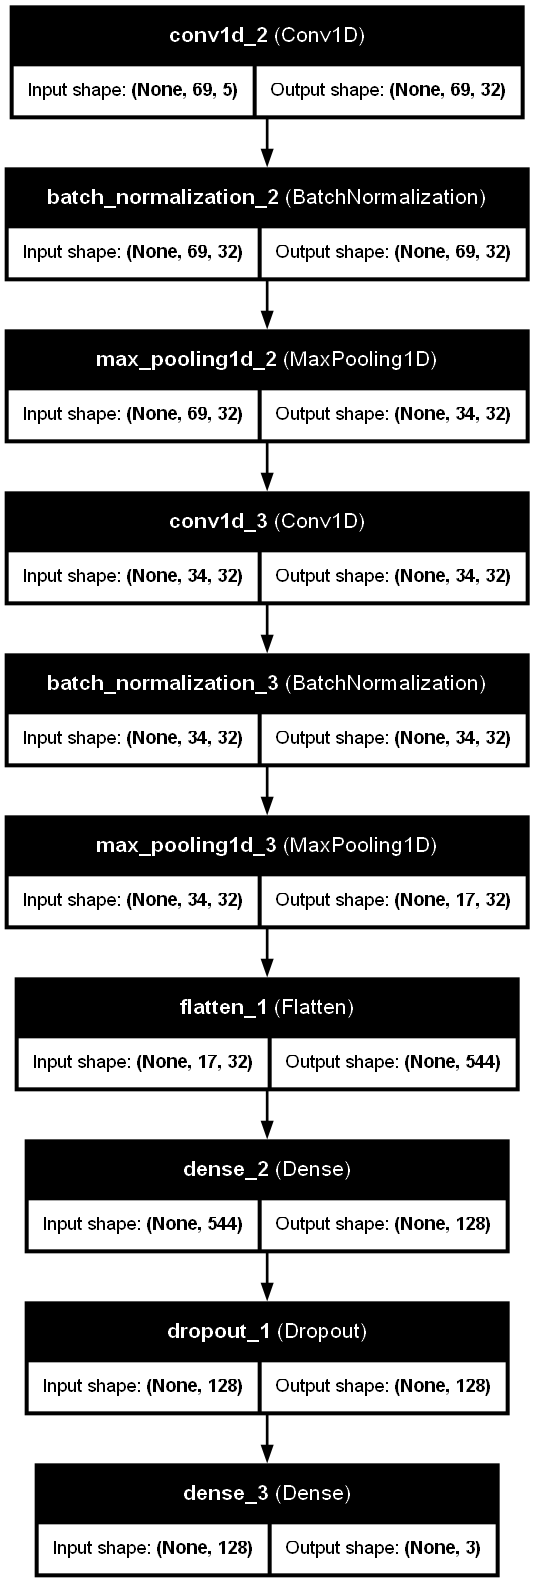

In [36]:


input_shape = (X_train_images.shape[1], X_train_images.shape[2])
model = create_model(input_shape)
learning_rate = 0.0001  
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

tf.keras.utils.plot_model(model, to_file='cnn_architecture.png', show_shapes=True, show_layer_names=True, dpi=96)





In [37]:
batch_size = 32
epochs = 50

# Train the model
history = model.fit(X_train_images, y_train_images, epochs=epochs, 
                batch_size=batch_size, validation_data=(X_val_images, y_val_images), verbose=1)



Epoch 1/50
10238/10238 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step - accuracy: 0.7976 - loss: 0.4679 - val_accuracy: 0.8154 - val_loss: 0.3582
Epoch 2/50
10238/10238 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - accuracy: 0.8110 - loss: 0.3584 - val_accuracy: 0.8111 - val_loss: 0.3482
Epoch 3/50
10238/10238 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - accuracy: 0.8095 - loss: 0.3377 - val_accuracy: 0.8100 - val_loss: 0.3456
Epoch 4/50
10238/10238 ━━━━━━━━━━━━━━━━━━━━ 48s 5ms/step - accuracy: 0.8092 - loss: 0.3266 - val_accuracy: 0.8112 - val_loss: 0.3474
Epoch 5/50
10238/10238 ━━━━━━━━━━━━━━━━━━━━ 48s 5ms/step - accuracy: 0.8116 - loss: 0.3143 - val_accuracy: 0.8096 - val_loss: 0.3486
Epoch 6/50
10238/10238 ━━━━━━━━━━━━━━━━━━━━ 50s 5ms/step - accuracy: 0.8104 - loss: 0.3048 - val_accuracy: 0.8090 - val_loss: 0.3510
Epoch 7/50
10238/10238 ━━━━━━━━━━━━━━━━━━━━ 51s 5ms/step - accuracy: 0.8121 - loss: 0.2946 - val_accuracy: 0.8066 - val_loss: 0.3571
Epoch 8/50
10238/10238 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 

In [40]:
print(len(y_train[y_train==2])/len(y_train),len(y_train[y_train==2])," Up")
print(len(y_train[y_train==0])/len(y_train),len(y_train[y_train==0]),"Down")
print(len(y_train[y_train==1])/len(y_train),len(y_train[y_train==1]),"Neutral")
print(len(y_train),"Training Size\n")

print(len(y_test_images[y_test_images==2])/len(y_test_images),len(y_test_images[y_test_images==2])," Up")
print(len(y_test_images[y_test_images==0])/len(y_test_images),len(y_test_images[y_test_images==0])," Down")
print(len(y_test_images[y_test_images==1])/len(y_test_images),len(y_test_images[y_test_images==1])," Neutral")
print(len(y_test_images),"Testing Size")

print("\n",len(y_test_images)/len(y_train_images))

0.021105714782852905 6914  Up
0.024164425545424296 7916 Down
0.8163644078403121 267432 Neutral
327589 Training Size

0.022822138328940807 1602  Up
0.018890234347175724 1326  Down
0.8349312629104637 58608  Neutral
70195 Testing Size

 0.21428026313781157


2194/2194 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Test Accuracy (using predictions): 0.8953344255288839
              precision    recall  f1-score   support

           0       0.49      0.21      0.29      5611
           1       0.91      0.98      0.94     62982
           2       0.03      0.00      0.00      1602

    accuracy                           0.90     70195
   macro avg       0.47      0.40      0.41     70195
weighted avg       0.86      0.90      0.87     70195

[[ 1179  4432     0]
 [ 1240 61667    75]
 [    1  1599     2]]
Test Accuracy (using model.evaluate): 0.8193318843841553


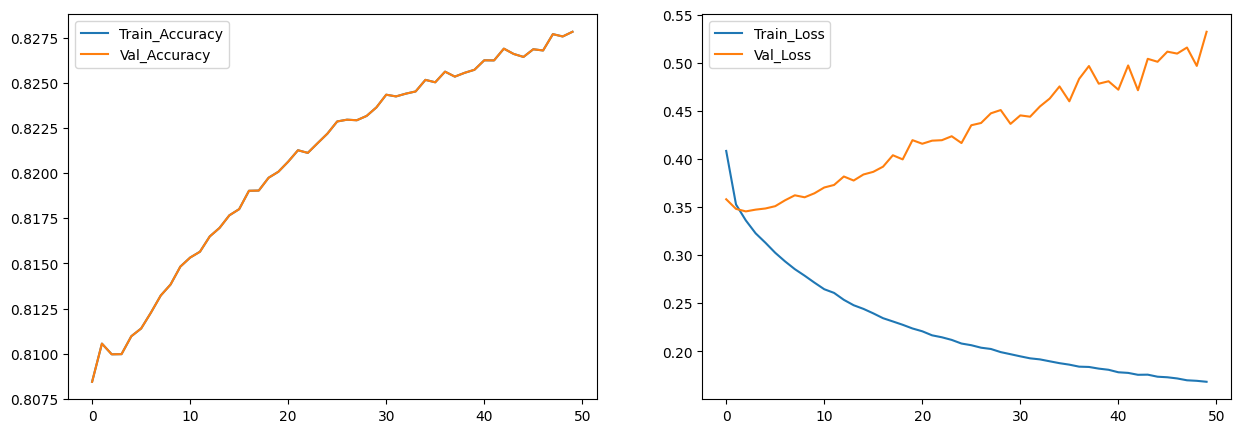

In [41]:
#Make predictions
predictions = model.predict(X_test_images)
predicted_labels = np.argmax(predictions, axis=1) #Axis 1 is for each sample
accuracy = accuracy_score(y_test_images.astype(int), predicted_labels)
print(f"Test Accuracy (using predictions): {accuracy}")

#Print classification report
print(classification_report(y_test_images.astype(int),predicted_labels))

#Print confusion matrix
print(confusion_matrix(y_test_images.astype(int),predicted_labels))

# Compare with model.evaluate (should be the same)
loss, accuracy_eval = model.evaluate(X_test_images, y_test_images, verbose=0)
print(f"Test Accuracy (using model.evaluate): {accuracy_eval}")

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(history.history["accuracy"],label="Train_Accuracy")
ax[0].plot(history.history["accuracy"],label="Val_Accuracy")
ax[1].plot(history.history["loss"],label="Train_Loss")
ax[1].plot(history.history["val_loss"],label="Val_Loss")
ax[0].legend()
ax[1].legend()
